<a href="https://colab.research.google.com/github/oduolaidrisA/Machine-Learning/blob/main/Multiple_Finite_well_problem_with_symmetry_included.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consider the problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) =
    \begin{cases}
        0 & -l < x <  l, \\
        V_0 &  otherwise.
    \end{cases}
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $l = 6$, $h = 1, m = 1 $ and $V_0 = 20$

In [ ]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy


#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))


cuda


In [ ]:
!pip install pyDOE
from pyDOE import lhs #latin hypercube sampling

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18171 sha256=dfa3bda191731c42cbad0040b370347621386938b27fe409598a8ed71e583e7d
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
#The sine activation function
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Automatic differentiation in pytorch
def dfx(f,x):
  gouts = torch.ones(x.shape, dtype=torch.float, device = device)
  return grad([f],[x],grad_outputs=gouts, create_graph=True)[0]

In [ ]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  dt1 = t - t0
  dt2 = t - tf
  f = (1-torch.exp(-dt1))*(1-torch.exp(dt2))
  psi_hat = bound + f*N1
  return psi_hat

In [ ]:
pred = 5000
def hamEqs_Loss(t,psi, v,itr):
  if itr < pred:
    psi_init = torch.exp(-(t-2.5)**2)
    #psi_init = 0.5*(torch.exp(-(t+2.5)**2) + torch.exp(-(t-2.5)**2))
    f = psi - psi_init
    L = (f.pow(2)).mean()
    return L
  else:
    psi_x = dfx(psi,t)
    psi_xx = dfx(psi_x,t)
    E  = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + v[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) ####
    f = (0.5*(psi_xx) + (E - v)*psi)#/torch.sqrt(torch.dot(psi[:,0],psi[:,0]))
    L = (f.pow(2)).mean()
    return L,E

In [ ]:
#defining the potential
def V(x):
  x = x.data.numpy()
  v = 20
  Vnp = (1 - np.heaviside(x+5,0) + np.heaviside(x+1/2,0) - np.heaviside(x-1/2,0) +np.heaviside(x-5,0))*v
  #Vnp = 1 + np.heaviside(x+5,0) - np.heaviside(x-5,0)
  return torch.from_numpy(Vnp)

#V_min = 0; V_right = 20; V_left = 20; V_max = min(V_right, V_left)

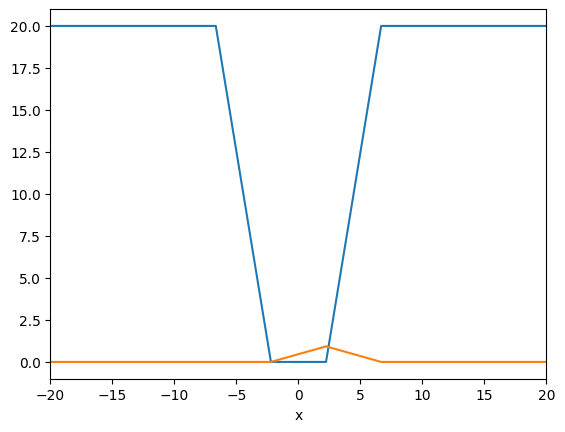

In [ ]:
x = torch.linspace(-20,20,10).view(-1,1)
pot =  V(x)

plt.plot(x,pot)
#plt.plot(x, torch.zeros_like(x), '--k')
plt.xlim(-20,20)
plt.xlabel('x',color='black')
plt.plot(x, np.exp(-(x-2.5)**2))
#plt.plot(x, 0.5*(np.exp(-(x+2.5)**2) + np.exp(-(x-2.5)**2)))
plt.show()
#pot.shape
#np.heaviside(x+5,0)+ np.heaviside(x+3,0)

In [ ]:
#Defining the NN architecture
class RqNN(torch.nn.Module):
  def __init__(self,layers):
    super(RqNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [ ]:
#Defining group equivariant RqPINN
class equiRqNN(torch.nn.Module):
  def __init__(self,layers):
    super(equiRqNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      if i ==len(layers)-2:
        nn.init.zeros_(self.linears[i].bias.data) #Initializing the bias of the last layer to zeros
      else:
        nn.init.normal_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x).float()
    a0 = torch.cat([x,-x], dim=0).view(2,-1,layers[0])
    #Implementing equivariance for l = 1
    z1 = self.linears[0](a0)
    a1 = self.activation(z1)

    #Implementing equivariance for 1 < l < L-1
    for i in range(1,len(self.linears)-1):
      z21 = self.linears[i](a1[0,:,:] - a1[1,:,:])
      z22 = self.linears[i](a1[1,:,:] - a1[0,:,:])
      z = torch.cat([z21,z22], dim = 0).view(2,-1,layers[i+1])
      a1 = self.activation(z)

    #Implementing equivariance for l = L
    out = self.linears[-1](a1[0,:,:] - a1[1,:,:])
    return out

In [ ]:
def points_inside_well(x):
  x = x.detach().cpu().numpy()
  PIW = np.heaviside(x-5,0) +np.heaviside(-x-5,0)
  return abs(PIW -1)

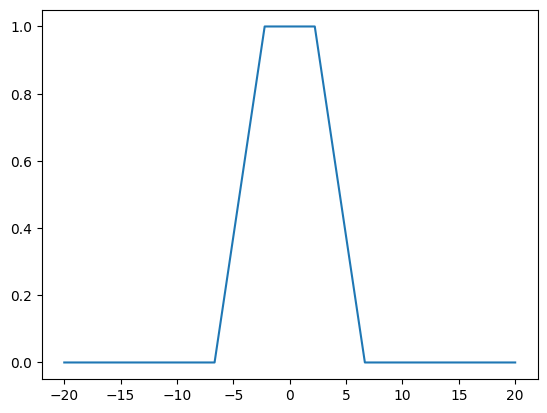

In [ ]:
plt.plot(x,points_inside_well(x))
plt.show()

In [ ]:
#Defining the hyperparameters
t0 =-20; tf = 20; xbc = 0
col_pts = 301; layers = [1,100,50,1]; lr = 1e-2; epochs =100000

In [ ]:
def save_checkpoint(state, filename='last_checkpoint_mfpwp.pth.tar'):
  print('=========================')
  print('Saving checkpoint')
  print('=========================')
  torch.save(state, filename)

In [ ]:
model = equiRqNN(layers)
model.to(device)
print(model)
params = list(model.parameters())
#print(params)
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)
#optimizer = optim.LBFGS(model.parameters(), lr=lr, max_iter=10, history_size = 10)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5, patience = 10, verbose = True)

equiRqNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


#### Loss Definition for LBFGS

In [ ]:
def criterion(itr, t_rand, psi, Vx):
  if itr < 5000:
    total_loss = hamEqs_Loss(t_rand,psi, Vx,itr)
    if itr % 500 == 0:
        print('--------------------------------------------')
        print('Epoch: ', itr)
        print('loss = ', total_loss.cpu().detach().numpy())
  else:
    pde_loss, En = hamEqs_Loss(t_rand,psi, Vx,itr)
    En_history.append(En.cpu().detach().numpy().item())
    NT = ( 1 - ((tf - t0) * torch.sqrt(torch.dot(psi[:,0],psi[:,0]))/ col_pts) ).pow(2)
    piw = torch.tensor(points_inside_well(t_rand)).to(device) #To remove the oscillations outside the well
    node_loss = abs((torch.sum(abs(torch.diff(torch.sign(torch.diff(psi[:,0]*piw[:,0])))/2)) - 2 - orth_counter))
    total_loss = NT + pde_loss  #+ node_loss

    if orth_counter > 0:
      diff = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + Vx[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) - En_counter[-1]
      #en_loss = 0 if diff > 0 else 5*torch.exp(-diff)
      en_loss = 5*torch.clamp(torch.sign(-diff), min=0)*torch.exp(-diff)
      ortho_loss = 0
      #Normalizing the orthogonal loss
      for i in range(orth_counter):
        psi_i = parametricSolutions(t_rand,dic[i],t0,tf,xbc)[:,0]
        ortho = torch.sqrt(torch.dot(psi_i, psi[:,0]).pow(2))/ (torch.sqrt(torch.dot(psi_i, psi_i) * torch.sqrt(torch.dot(psi[:,0], psi[:,0]))))
        ortho_loss += ortho
      total_loss +=  0.5*ortho_loss + en_loss

    if i % 500 == 0:
      print('--------------------------------------------')
      print('Epoch: ', i)
      print('En: ', En_history[-1])
      print('oc: ', orth_counter)
      print('--------------------------------------------')
      print('Total_loss: ',total_loss.cpu().detach().numpy())
      if orth_counter > 0:
        print('ortho_loss: ', ortho_loss.cpu().detach().numpy())
        print('en_loss: ',en_loss.cpu().detach().numpy())
      print('pde_loss: ', pde_loss.cpu().detach().numpy())
      print('NT: ', NT.cpu().detach().numpy())
      print('no of nodes: ',node_loss.cpu().detach().numpy())

  return total_loss


In [ ]:
#Defining the closure function for the LBFGS
def closure(itr, t_rand, psi, Vx):
  optimizer.zero_grad()
  total_loss = criterion(itr, t_rand, psi, Vx)
  total_loss.backward()
  return total_loss

#### USING LBFGS OPTIMIZER

In [ ]:
#To learn multiple eigenvlues and eigenvectors, we will need both the orthogonality and orthonormality ppty
def nn_train_lbfgs(RqNN,t0,tf,xbc,col_pts,checkpoints, epochs, x):
  En_history = [] #To store the eigenvalues as it is optimized
  SE_loss_hist = [] #To store the pde loss
  internal_loss_hist = [] #To compute loss for rolling mean
  Loss_hist = []#To store the total loss after every epoch
  #grid = torch.linspace(t0,tf,col_pts).view(-1,1) #The collocation points
  t_rand = x.to((device))
  t_rand.requires_grad =True
  orth_counter = 0
  En_counter = []
  #Dictionary for storing the learned eigenfunction
  dic = {}
  load_model = False #To load the model from the last checkpoint


  stime = time.time()
  if load_model:
    print('=========================')
    print('Loading checkpoint')
    print('=========================')
    checkpoint = torch.load('last_checkpoint_mfpwp.pth.tar')
    RqNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
    current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; Loss_hist = checkpoint['Loss_hist']
    En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']
    print('=========================')
    print('Loaded checkpoint')
    print('=========================')
  else:
    current = 0
  for iter in range(current+1,epochs + 1):
    loss = 0.0
    #Getting the parametric solution
    psi = parametricSolutions(t_rand,RqNN,t0,tf,xbc).to(device)
    Vx = V(t_rand.cpu()).to(device)

    #Derivatives needed when computing en_loss
    psi_x = dfx(psi,t_rand)
    psi_xx = dfx(psi_x,t_rand)

    if iter == 4900:
      checkpoint = {'psi': psi}
      save_checkpoint(checkpoint,'psi.pth.tar')

    for index, breakpoint in enumerate(breakpoints):
      if iter == breakpoint and orth_counter == index:
        dic[index] = copy.deepcopy(RqNN)
        En_counter.append(En_history[-1])
        orth_counter += 1
        psi_i = parametricSolutions(t_rand, dic[index],t0,tf,xbc)
        psi = psi_i #* (t_rand) # max is at 0
        print('==========================================')
        print(f"Learned {index+1} Eigenvalues")
        print('==========================================')
        #saving a checkpoint for future iterations
        checkpoint = {
            'state_dict': RqNN.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': iter, 'Loss_hist': Loss_hist,
            'orth_counter': orth_counter, 'En_history': En_history, 'dic': dic, 'En_counter': En_counter
        }
        save_checkpoint(checkpoint)


    #Backward Propagation using LBFGS
    total_loss = optimizer.step(closure(iter, t_rand, psi, Vx))


    #Storing the loss after each iteration
    loss += total_loss.cpu().detach().numpy()
    Loss_hist.append(loss)
    #Scheduling the learning rate
    #scheduler.step(total_loss)


  #Storing the final eigenfunction and eigenvalue
  dic[orth_counter] = copy.deepcopy(RqNN)
  En_counter.append(En_history[-1])


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return Loss_hist, En_history, En_counter, dic

#### USING ADAM OPTIMIZER

In [ ]:
def nn_train(NN,t0,tf,xbc,col_pts,epochs,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_dic = {} #To store the losses
  loss_dic['pde_loss_hist'] = []; loss_dic['NT_hist'] = []; loss_dic['ortho_loss_hist'] = [];
  loss_dic['loss_hist'] = []; loss_dic['en_loss_hist'] = []; rm_hist = []; iter_store = [pred]
  #t_rand = t[torch.randperm(t.shape[0])].to(device) #Reshuffling the collocation points
  t_rand = t.to(device) #predictor collocation points
  t_rand.requires_grad =True

  load_model = True #To load the model from the last checkpoint
  window = 500 #For rolling mean
  orth_counter = 0
  En_counter = []
  #Dictionary for storing the learned eigenfunction
  dic = {}

  stime = time.time()
  if load_model:
    print('=========================')
    print('Loading checkpoint')
    print('=========================')
    checkpoint = torch.load('last_checkpoint_mfpwp.pth.tar')
    NN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
    current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; loss_dic = checkpoint['loss_dic']
    En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']; iter_store = checkpoint['iter_store']
    print('=========================')
    print('Loaded checkpoint')
    print('=========================')
  else:
    current = -1
  for iter in range(current+1,epochs + 1):
    loss = 0.0
    #Getting the parametric solution
    psi = parametricSolutions(t_rand,NN,t0,tf,xbc).to(device)
    #Getting the potential
    Vx = V(t_rand.clone().cpu()).to(device)

    if iter < pred:
      #Getting the PDE loss
      total_loss = hamEqs_Loss(t_rand,psi, Vx,iter)
      if iter % 1000 == 0:
        print('--------------------------------------------')
        print('Epoch: ', iter)
        print('loss = ', total_loss.cpu().detach().numpy())
      if iter == (pred - 5):
        pre_model = copy.deepcopy(NN)
        checkpoint = {'dic': pre_model}
        save_checkpoint(checkpoint,'psi.pth.tar')
    else:

      #Derivatives needed when computing en_loss
      psi_x = dfx(psi,t_rand)
      psi_xx = dfx(psi_x,t_rand)
      pde_loss, En = hamEqs_Loss(t_rand,psi, Vx,iter)
      En_history.append(En.cpu().detach().numpy().item())
      #Getting the loss after the forward pass
      loss_dic['pde_loss_hist'].append(pde_loss.cpu().detach().numpy())

      criteria_loss = pde_loss


      #Adding the normalization as a regularization term
      NT = ( 1 - ((tf - t0) * torch.sqrt(torch.dot(psi[:,0],psi[:,0]))/ col_pts) ).pow(2)
      #computing the nodes of the eigenfunction
      piw = torch.tensor(points_inside_well(t_rand)).to(device) #To remove the oscillations outside the well

      node_loss = abs((torch.sum(abs(torch.diff(torch.sign(torch.diff(psi[:,0]*piw[:,0])))/2)) - 2 - orth_counter))
      total_loss = NT  + criteria_loss
      #Storing the losses
      loss_dic['NT_hist'].append(NT.cpu().detach().numpy())

      #Defining the Rolling Mean Error estimate
      if len(En_history) > window:
        rmean = np.mean(np.array(En_history[-window:])-np.array(En_history[-window-1:-1]))
      else:
        rmean = np.mean(np.array(En_history[1:])-np.array(En_history[:-1]))


      #Storing the rm after each epoch
      rm_hist.append(rmean)

      #Defining the minimum training
      iter_diff = iter - iter_store[-1]


      if abs(rmean) < 5e-9 and iter_diff > 9000:
        dic[orth_counter] = copy.deepcopy(NN)
        iter_store.append(iter)
        En_counter.append(En_history[-1])
        orth_counter += 1
        print('==========================================')
        print(f"Learned {orth_counter} Eigenvalues")
        print('==========================================')
        #saving a checkpoint for future iterations
        checkpoint = {
            'state_dict': NN.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': iter, 'loss_dic': loss_dic,
            'orth_counter': orth_counter, 'En_history': En_history, 'dic': dic, 'En_counter': En_counter,
            'iter_store': iter_store
        }
        save_checkpoint(checkpoint)


      #Calculating condition for the orthogonality loss
      #Getting the condition for the en_loss
      if orth_counter > 0:
        diff = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + Vx[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) - En_counter[-1]
        #en_loss = 0 if diff > 0 else 5*torch.exp(-diff)
        en_loss = 5*torch.clamp(torch.sign(-diff), min=0)*torch.exp(-diff)
        ortho_loss = 0

        #Normalizing the orthogonal loss
        for i in range(orth_counter):
          psi_i = parametricSolutions(t_rand,dic[i],t0,tf,xbc)[:,0]
          ortho = torch.sqrt(torch.dot(psi_i, psi[:,0]).pow(2))/ (torch.sqrt(torch.dot(psi_i, psi_i) * torch.sqrt(torch.dot(psi[:,0], psi[:,0]))))
          ortho_loss += ortho

        total_loss +=  ortho_loss/3 + en_loss
        #Saving the remaining losses
        loss_dic['ortho_loss_hist'].append(ortho_loss.cpu().detach().numpy())
        loss_dic['en_loss_hist'].append(en_loss.cpu().detach().numpy())


      if iter % 300 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print(f'En: {En_history[-1]}')
        print(f'oc: {orth_counter}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.cpu().detach().numpy())
        print('rm: ', rmean)
        if orth_counter > 0:
          print('ortho_loss: ', loss_dic['ortho_loss_hist'][-1])
          #print('en_loss: ',loss_dic['en_loss_hist'][-1])
        print('pde_loss: ', criteria_loss.cpu().detach().numpy())
        print('NT: ', loss_dic['NT_hist'][-1])
        print('no of nodes: ',node_loss.cpu().detach().numpy())
        #for name, param in NN.named_parameters():
        #  if param.grad is not None:
        #    print(f'Parameter: {name}, Gradient Norm: {torch.norm(param.grad)}')
        if  orth_counter == 6:
          print('==========================================')
          print(f"Completely learned all Eigenvalues")
          break
          print('==========================================')

    #Backward propagation
    optimizer.zero_grad()
    total_loss.backward()
    #Introducing Gradient clipping
    #max_norm =1.0
    #torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm)
    optimizer.step()
    loss += total_loss.cpu().detach().numpy()


    #Storing the loss after each iteration
    loss_dic['loss_hist'].append(loss)
    #Scheduling the learning rate
    #scheduler.step(total_loss)


  #Storing the final eigenfunction and eigenvalue
  dic[orth_counter] = copy.deepcopy(NN)
  En_counter.append(En_history[-1])


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, En_history, En_counter, dic, rm_hist, iter_store

#### Training

In [ ]:
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()
x_lhs.shape

torch.Size([301, 1])

In [ ]:
#import scipy.special as sp

#x, _ = sp.roots_chebyt(col_pts)
#x_cheb = 20*torch.tensor(x).view(-1,1).float()
#x_uniform = torch.linspace(t0,tf,col_pts).view(-1,1)
Loss, eig_vals, eig_count, qPINN, rm_hist, iter_store = nn_train(model,t0,tf,xbc,col_pts,epochs,x_lhs)

Loading checkpoint
Loaded checkpoint
--------------------------------------------
Epoch: 53400
En: 5.28150749206543
oc: 5
--------------------------------------------
Total_loss:  0.9998892
rm:  0.0004865264892578125
ortho_loss:  2.1749687
pde_loss:  0.10034186
NT:  0.17455775
no of nodes:  100.0
--------------------------------------------
Epoch: 53700
En: 5.440507411956787
oc: 5
--------------------------------------------
Total_loss:  1.0120956
rm:  0.0008028507232666016
ortho_loss:  1.5217817
pde_loss:  0.051301733
NT:  0.4535333
no of nodes:  100.0
--------------------------------------------
Epoch: 54000
En: 5.603684425354004
oc: 5
--------------------------------------------
Total_loss:  0.9620925
rm:  0.0005059089660644532
ortho_loss:  1.8750703
pde_loss:  0.10371782
NT:  0.23335123
no of nodes:  99.0
--------------------------------------------
Epoch: 54300
En: 6.005631446838379
oc: 5
--------------------------------------------
Total_loss:  0.8966442
rm:  0.000952700614929199

##Predictions


In [ ]:
checkpoint = torch.load('last_checkpoint_mfpwp.pth.tar', map_location=torch.device('cpu'))
Loss = checkpoint['loss_dic']; En_counter = checkpoint['En_counter']; dic = checkpoint['dic'];
iter_store = checkpoint['iter_store']; En_history = checkpoint['En_history']

In [ ]:
eigs = np.array(En_counter)

In [ ]:
tTest = torch.linspace(-20,20,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi = {}; psi_neg = {}
#psi1 =parametricSolutions(tTest,dic[0].cpu(),t0,tf,xbc).data.numpy()
#psi2 =parametricSolutions(tTest,dic[1].cpu(),t0,tf,xbc).data.numpy()
#psi3 = parametricSolutions(tTest,dic[2].cpu(),t0,tf,xbc).data.numpy()
for i in range(len(dic)):
  psi[i] = parametricSolutions(tTest,dic[i].cpu(),t0,tf,xbc).data.numpy()
  psi[i] = 0.2 * psi[i]/max(abs(psi[i]))

In [ ]:
for i in range(len(dic)):
  psi_neg[i] = parametricSolutions(-tTest,dic[i].cpu(),t0,tf,xbc).data.numpy()
  psi_neg[i] = 0.4 * psi_neg[i]/max(abs(psi_neg[i]))

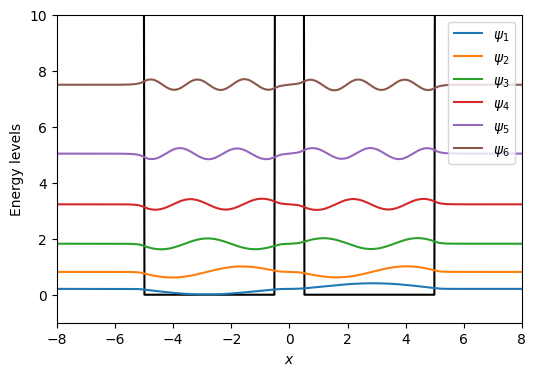

In [ ]:
fig, ax1 = plt.subplots(figsize = (6,4))
x = torch.linspace(-20,20,1200).view(-1,1)
pot = V(x)
ax1.plot(x,pot, 'k')
ax1.plot(t_net, eigs[0]+psi[0], label ='$\psi_{1}$')
ax1.plot(t_net, eigs[1]+psi[1], label ='$\psi_{2}$')
ax1.plot(t_net, eigs[2]+psi[2], label ='$\psi_{3}$')
ax1.plot(t_net, eigs[3]+psi[3], label ='$\psi_{4}$')
ax1.plot(t_net, eigs[4]+psi[4], label ='$\psi_{5}$')
ax1.plot(t_net, eigs[5]+psi[5], label ='$\psi_{6}$')
ax1.set_ylim(-1,10); ax1.set_xlim(-8,8)

plt.xlabel('$x$'); plt.ylabel('Energy levels')
plt.legend(loc = "upper right")
plt.show()

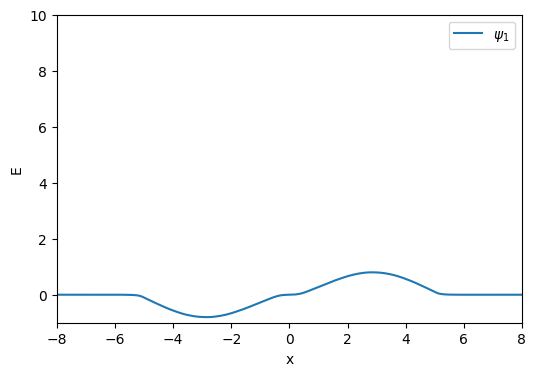

In [ ]:
ig, ax1 = plt.subplots(figsize = (6,4))
x = torch.linspace(-20,20,1200).view(-1,1)
pot = V(x)
ax1.plot(t_net, psi[0]-psi_neg[0], label ='$\psi_{1}$')
#ax1.plot(t_net, psi_neg[1]-psi[1], label ='$\psi_{2}$')
#ax1.plot(t_net, psi_neg[2]-psi[2], label ='$\psi_{3}$')
#ax1.plot(t_net, psi_neg[3]-psi[3], label ='$\psi_{4}$')
#ax1.plot(t_net, psi_neg[4]-psi[4], label ='$\psi_{5}$')
#ax1.plot(t_net, psi_neg[5]-psi[5], label ='$\psi_{6}$')
ax1.set_ylim(-1,10); ax1.set_xlim(-8,8)

plt.xlabel('x'); plt.ylabel('E')
plt.legend(loc = "upper right")
plt.show()

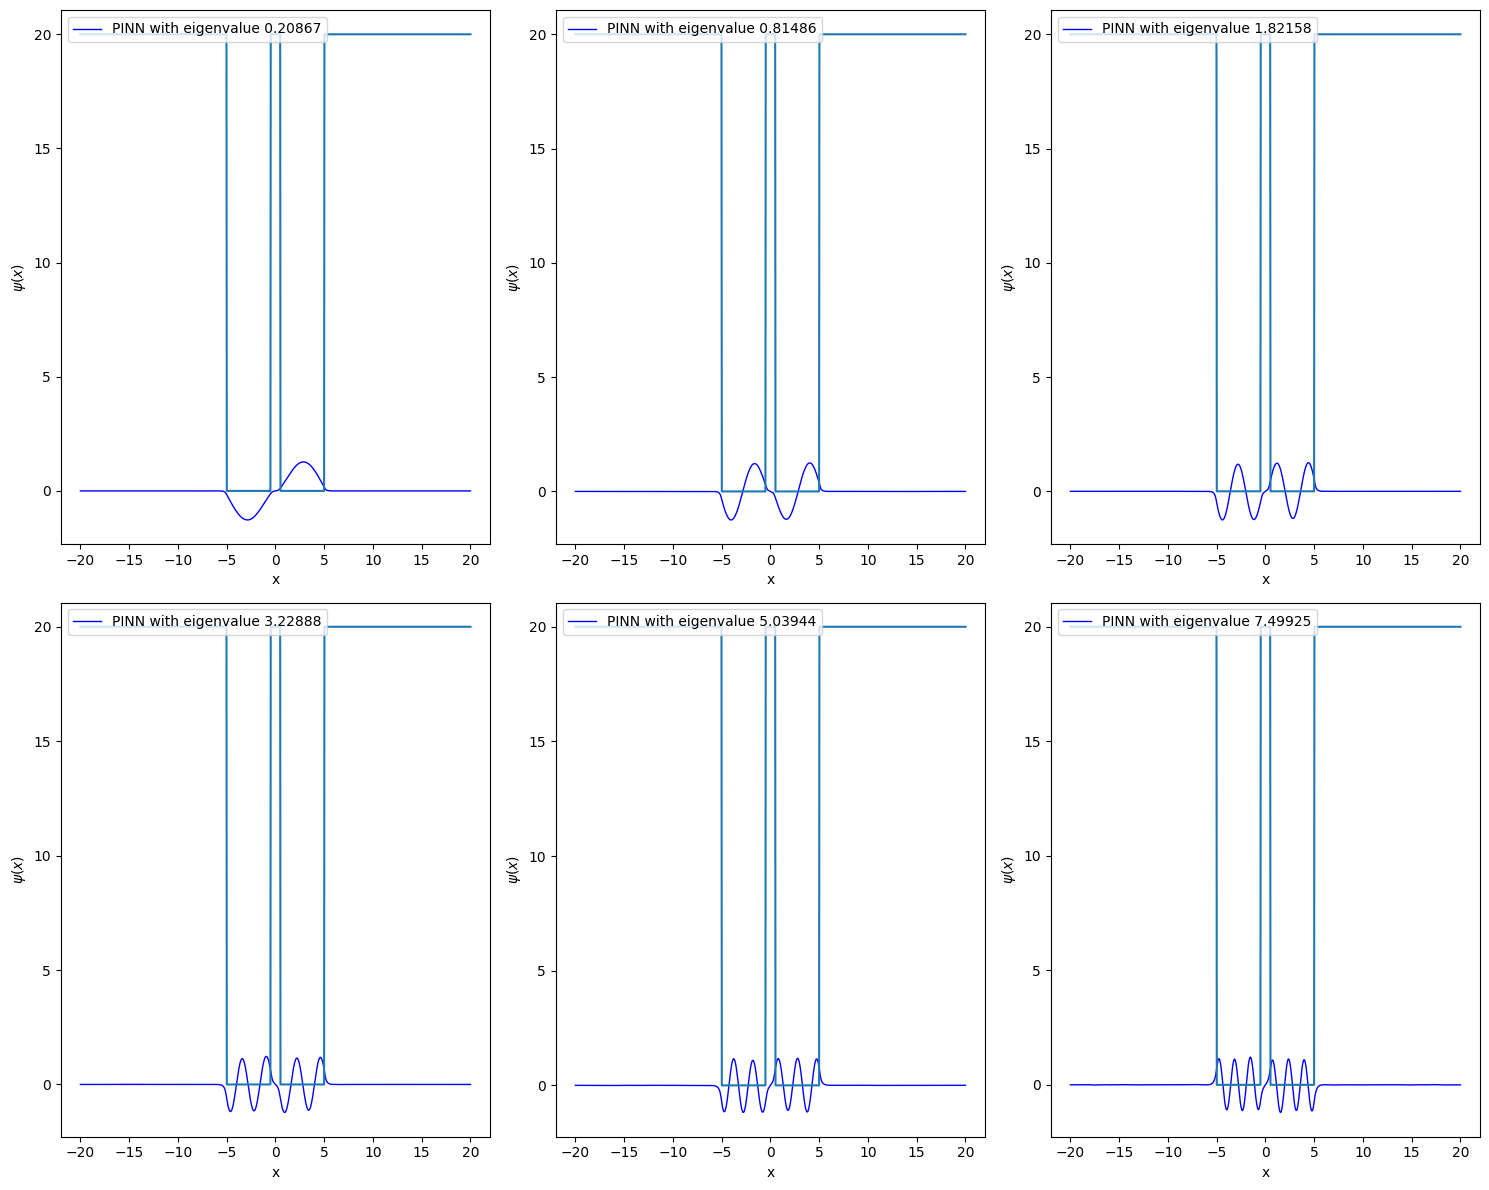

In [ ]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculate the total number of subplots needed
total_subplots = len(psi)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterate over eigenvalues and corresponding solutions
for index, eig in enumerate(En_counter[:total_subplots]):
    row_index = index // num_cols  # Calculate row index
    col_index = index % num_cols   # Calculate column index

    # Plot on the corresponding subplot
    ax = axes[row_index, col_index]
    ax.plot(t_net, psi[index], color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[index]:.5f}')
    ax.plot(t_net, V(torch.tensor(t_net)).numpy())
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hide the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
En_counter

[0.20867417752742767,
 0.8148623108863831,
 1.821579098701477,
 3.2288756370544434,
 5.039438724517822,
 7.499251842498779]

In [ ]:
iter_store

[5000, 14706, 24237, 33681, 43253, 53235, 63162]

In [ ]:
np.array(iter_store[1:])- np.array(iter_store[:-1])

array([9706, 9531, 9444, 9572, 9982, 9927])

In [ ]:
#Solution from Chebfun
chebfun =[0.212641916674322, 0.849941914561526, 1.909928504528237, 3.388963245314535, 5.281045713816265, 7.576352019204817]
relative_err = np.abs((np.array(En_counter) - np.array(chebfun)))/np.abs(np.array(chebfun))
relative_err

array([0.01865925, 0.04127294, 0.04625796, 0.04723793, 0.04574984,
       0.01017642])

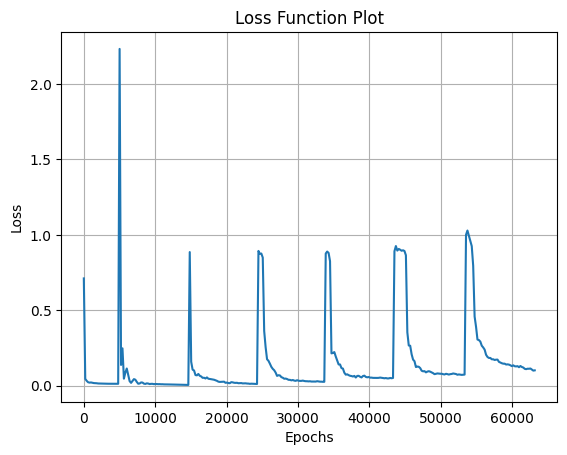

In [ ]:
#Plotting the loss function
loss = np.array(Loss['loss_hist'][::200]); ep = np.linspace(0,iter_store[-1],loss.shape[0])
plt.plot(ep, loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function Plot')
plt.grid('on')
plt.show()

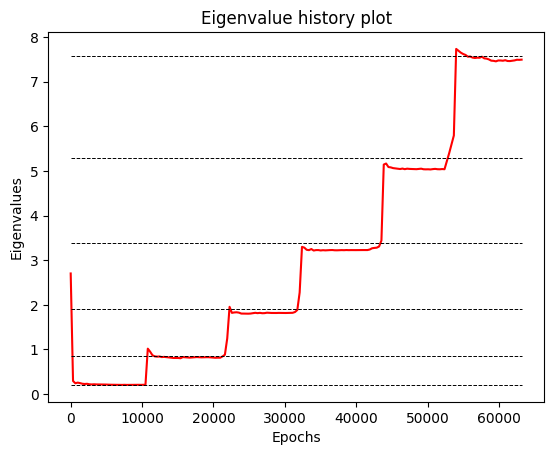

In [ ]:
#Plotting the energy levels
en = np.array(En_history[::300]); ep = np.linspace(0,iter_store[-1],en.shape[0])
plt.plot(ep,en, 'r')
plt.plot(ep, chebfun[0]*np.ones(len(ep)),'--k', linewidth = 0.7)
plt.plot(ep, chebfun[1]*np.ones(len(ep)),'--k', linewidth = 0.7)
plt.plot(ep, chebfun[2]*np.ones(len(ep)),'--k', linewidth = 0.7)
plt.plot(ep, chebfun[3]*np.ones(len(ep)),'--k', linewidth = 0.7)
plt.plot(ep, chebfun[4]*np.ones(len(ep)),'--k', linewidth = 0.7)
plt.plot(ep, chebfun[5]*np.ones(len(ep)),'--k', linewidth = 0.7)
plt.xlabel('Epochs')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalue history plot')

plt.show()

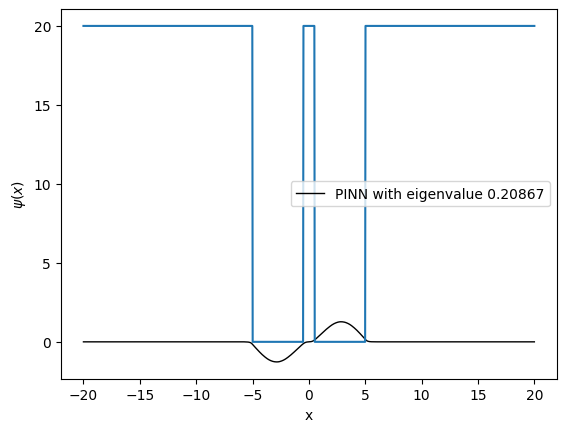

In [ ]:
j = 0
fig, ax1 = plt.subplots()
ax1.plot(t_net, psi[j], color='black', linewidth=1, label=f'PINN with eigenvalue {En_counter[j]:.5f}')
ax1.plot(t_net, V(torch.tensor(t_net)).numpy())
#ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')
plt.show()

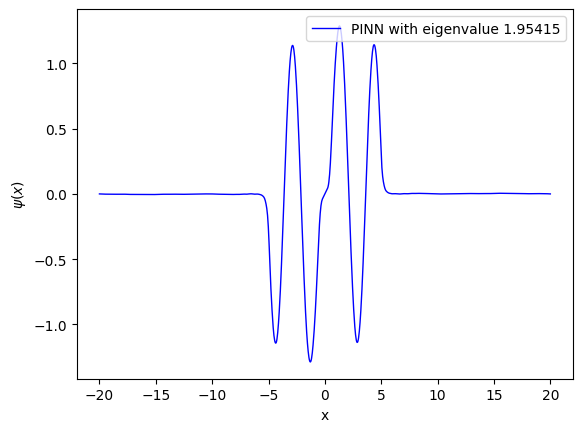

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(t_net, psi[2], color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[2]:.5f}')
#ax1.plot(t_net, V(torch.tensor(t_net)).numpy())

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')
plt.show()

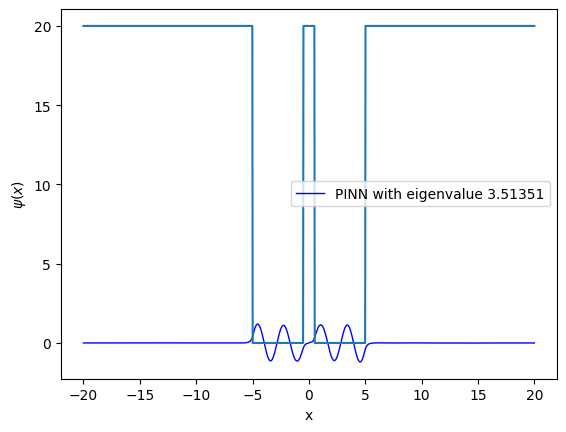

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(t_net, psi[3], color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[3]:.5f}')
ax1.plot(t_net, V(torch.tensor(t_net)).numpy())

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend()

#plt.grid('on')
plt.show()

In [ ]:
En_counter

[0.21126878261566162,
 1.8388190269470215,
 5.1560282707214355,
 7.422765254974365,
 10.08025074005127]

In [ ]:
En_chebfun = np.array([0.212744850605803, 1.911089951780468, 5.286231772731786])
En_Rqpinn = np.array([0.21126878261566162, 1.8388190269470215, 5.1560282707214355])

relative_err = abs((En_chebfun - En_Rqpinn)/En_chebfun)
relative_err

array([0.00693821, 0.0378166 , 0.02463068])